<a href="https://colab.research.google.com/github/nichakornchaisuwan/Project_Boneage/blob/main/BoneAgePredictor_limit128_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [6]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [7]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4609, 68)
        self.fc2 = nn.Linear(69, 1)
        #self.fc2 = nn.Linear(64, 1)
    
        

    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,4608)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', 'EPOCH {} '.format(epoch))
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [11]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=32, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=32, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=32, shuffle=True, **kwargs)

In [13]:
device

device(type='cpu')

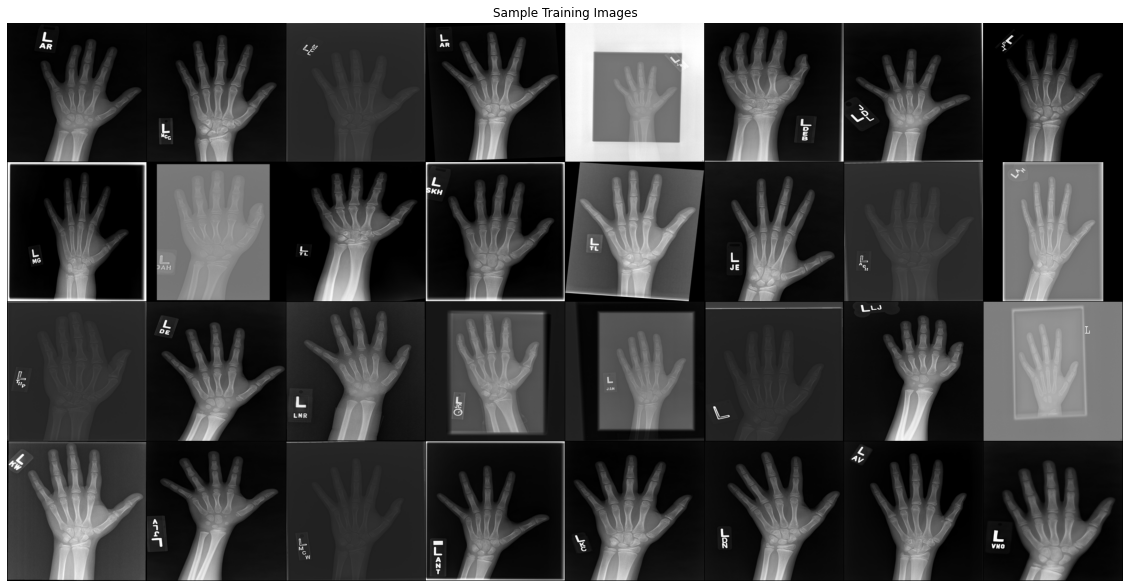

In [14]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [15]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [ ]:
train_losses = []
val_losses = []
for epoch in range(3):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_checkpoint.npy')

In [ ]:
checkpoint = torch.load('model_checkpoint.npy')
#checkpoint

In [ ]:
model.load_state_dict(checkpoint['state_dict'])
model

In [ ]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

In [ ]:
epoch = checkpoint['epoch']
epoch

In [ ]:
train_loss = checkpoint['train_loss']
train_loss

In [ ]:
val_loss = checkpoint['val_loss']
val_loss

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [ ]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)

#Grad-CAM


In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np

In [ ]:
class FeatureExtractor():
    """ 
    Class for extracting activations and
        registering gradients from targetted intermediate layers 
    """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

In [ ]:
class ModelOutputs():
    """ 
    Class for making a forward pass, and getting:
        1. The network output.
        2. Activations from intermeddiate targetted layers.
        3. Gradients from intermeddiate targetted layers. 
    """

    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model(output)
        return target_activations, output

In [ ]:
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = Variable(preprocessed_img, requires_grad=True)
    return input

In [ ]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("./cam_based/grad_cam.jpg", np.uint8(255 * cam))
    plt.imshow(Image.open('./cam_based/grad_cam.jpg'))
    plt.axis('off')
    plt.show()

In [ ]:
class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [ ]:
if __name__ == '__main__':
    image_path = './cam_based/test.jpg'
    # Can work with any model, but it assumes that the model has a
    # feature method, and a classifier method,
    # as in the VGG models in torchvision.
    grad_cam = GradCam(model=models.vgg19(pretrained=True), target_layer_names=["35"], use_cuda=False)

    img = cv2.imread(image_path, 1)
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input = preprocess_image(img)

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested index.
    target_index = None

    mask = grad_cam(input, target_index)
    
    show_cam_on_image(img, mask)